#  SETUP


In [1]:
%%capture
!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install pysteps

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance

# +
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy


from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from functools import partial
from abc import abstractmethod
from skimage.transform import rescale

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, SR_BC_GFDL_Dataset_256, QM_GFDL_LR_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [4]:
from src.dataloader_sr import gfdl_eval, CustomDataset

In [5]:
from src.dataloader_sr import GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM

In [6]:
bs_val = 7300

In [7]:
ds_era5_hr = era5_0_25d_256(stage='test')

In [8]:
ds_dm_ssp_fut = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/'
                          ,n_files=3, mode='last')
dl_dm_ssp_fut = data.DataLoader(ds_dm_ssp_fut, batch_size=26*365, shuffle=False,drop_last=True)
dm_ssp_future = next(iter(dl_dm_ssp_fut))
dm_ssp_future = ds_era5_hr.inverse_dwd_trafo(dm_ssp_future)
dm_ssp_future = dm_ssp_future[-int(bs_val):]      # when 26 in gfdl_ssp585_ds_fut then comment out
print("DM future 0.25d 256",dm_ssp_future.shape, len(dm_ssp_future), dm_ssp_future.max() )


gfdl_ssp585_ds_fut = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("2081_2100")
gfdl_ssp585_dl_fut = data.DataLoader(gfdl_ssp585_ds_fut, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_ssp585_future = next(iter(gfdl_ssp585_dl_fut))

print("GFDL SSP585 future 1d 64 shape:",gfdl_ssp585_future.shape, len(gfdl_ssp585_future), gfdl_ssp585_future.max() )

DM future 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300 tensor(501.3048)
dataset size (7300, 180, 288)
GFDL SSP585 future 1d 64 shape: torch.Size([7300, 1, 64, 64]) 7300 tensor(306.3120)


In [9]:
ds_dm_past = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_dm_gfdl_1995_2014/'
                          ,n_files=3, mode='first')
dl_dm_past = data.DataLoader(ds_dm_past, batch_size=bs_val, shuffle=False,drop_last=True)
dm_past = next(iter(dl_dm_past))
dm_past = ds_era5_hr.inverse_dwd_trafo(dm_past)
#dm_ssp_past = F.avg_pool2d(dm_ssp_past, kernel_size=4, stride=4)

print("DM past 0.25d 256", dm_past.shape, len(dm_past) )


gfdl_past_ds = gfdl_eval("1995_2014")
gfdl_past_dl = data.DataLoader(gfdl_past_ds, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_past = next(iter(gfdl_past_dl))
gfdl_past = gfdl_past_ds.inverse_dwd_trafo(gfdl_past)

print("GFDL past 1d 64 shape:",gfdl_past.shape)

DM past 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300
GFDL past 1d 64 shape: torch.Size([7300, 1, 64, 64])


In [10]:
ds_era5_hr = era5_0_25d_256(stage='test')
dl_era5_hr = torch.utils.data.DataLoader(ds_era5_hr, batch_size=365*20, shuffle=False, drop_last=True) 
era5_ref = next(iter(dl_era5_hr))
era5_ref = ds_era5_hr.inverse_dwd_trafo(era5_ref)
data_era5_ref_lr = F.avg_pool2d(era5_ref, kernel_size=4, stride=4)
era5_ref.shape, data_era5_ref_lr.shape

(torch.Size([7300, 1, 256, 256]), torch.Size([7300, 1, 64, 64]))

In [12]:
print("GFDL past 1d 64 shape:",gfdl_past.shape)
print("DM past 0.25d 256", dm_past.shape )
print("GFDL SSP585 future 1d 64 shape:",gfdl_ssp585_future.shape )
print("DM future 0.25d 256",dm_ssp_future.shape)

GFDL past 1d 64 shape: torch.Size([7300, 1, 64, 64])
DM past 0.25d 256 torch.Size([7300, 1, 256, 256])
GFDL SSP585 future 1d 64 shape: torch.Size([7300, 1, 64, 64])
DM future 0.25d 256 torch.Size([7300, 1, 256, 256])


# R95p (future - past) 

In [19]:
def calculate_r95p_per_year(input_data, reference, p=95, days_per_year=365):
    input_array = np.array(input_data)
    ref_array = np.array(reference)
    T, H, W = input_array.shape
    num_years = T // days_per_year

    # Calculate 95th percentile of wet days in the reference period
    wet_days = np.where(ref_array >= 1.0, ref_array, np.nan)
    rrwn95 = np.nanpercentile(wet_days, p, axis=0)  # shape (H, W)

    # Initialize output arrays
    r95p_per_year = np.zeros((num_years, H, W))
    days_above_per_year = np.zeros((num_years, H, W))

    for year in range(num_years):
        start = year * days_per_year
        end = start + days_per_year
        yearly_data = input_array[start:end]  # shape (365, H, W)

        # Apply threshold comparison
        above_threshold = np.where(yearly_data > rrwn95, yearly_data, np.nan)
        count_above = np.where(yearly_data > rrwn95, 1, np.nan)

        # Sum and count
        r95p_per_year[year] = np.nansum(above_threshold, axis=0)
        days_above_per_year[year] = np.nansum(count_above, axis=0)

    return r95p_per_year, days_above_per_year

In [20]:
r95p_gfdl_past_year, _ = calculate_r95p_per_year(gfdl_past.squeeze(1), data_era5_ref_lr.squeeze(1), p=95)
r95p_dm_past_year, _ = calculate_r95p_per_year(dm_past.squeeze(1), era5_ref.squeeze(1))
r95p_gfdl_ssp_year, _ = calculate_r95p_per_year(gfdl_ssp585_future.squeeze(1), data_era5_ref_lr.squeeze(1))
r95p_dm_ssp_year, _ = calculate_r95p_per_year(dm_ssp_future.squeeze(1), era5_ref.squeeze(1))

Saving to figures_paper/climate_change_r95p.pdf


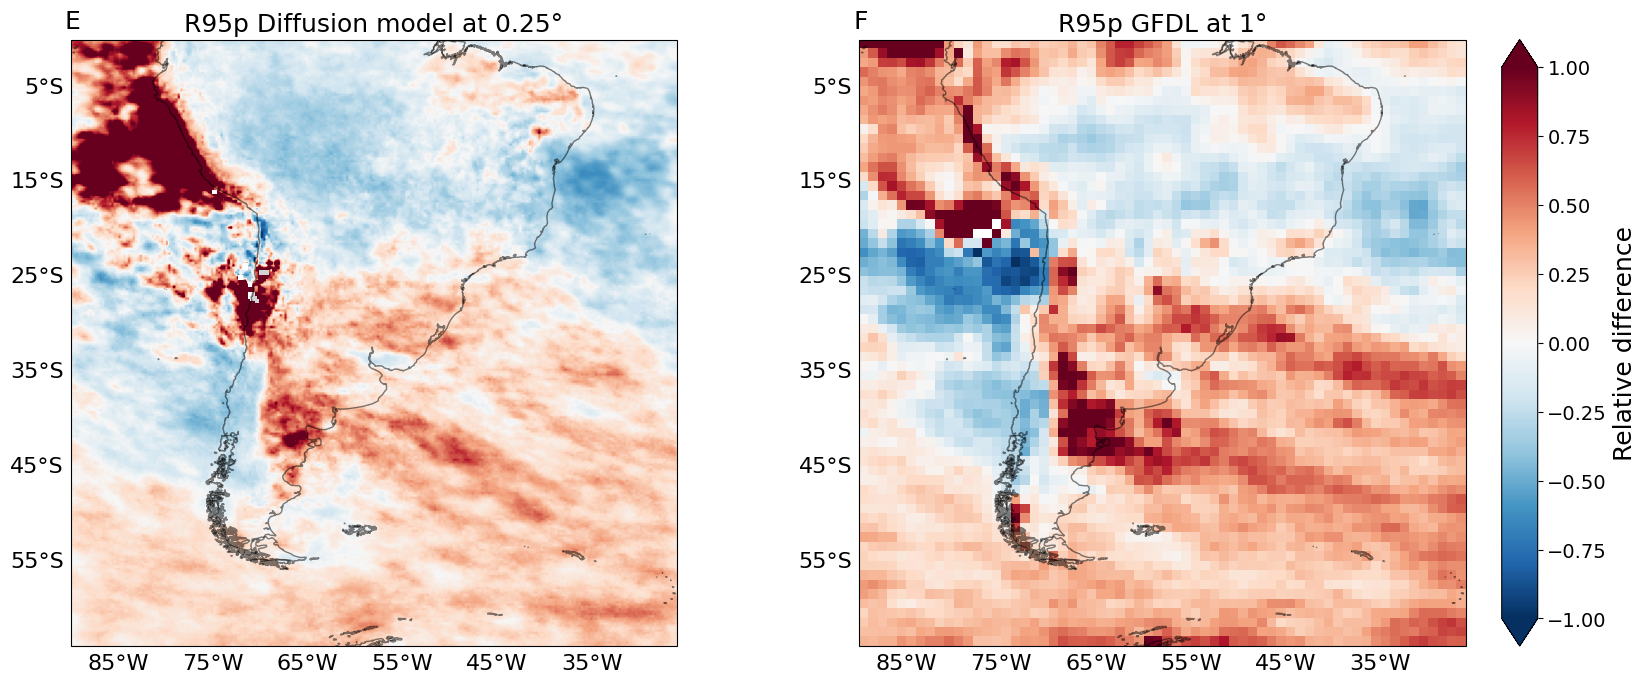

In [26]:
def plot_precipitation(ax, data, title, min_value=3, max_value=3):
    cmap = 'RdBu_r'
    norm = plt.Normalize(vmin=min_value, vmax=max_value)
    img = ax.imshow(data, cmap , norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img
    
latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.3, hspace=0.3)

max_value = 1 #120
min_value = -1 #-200


img1 = plot_precipitation(axes[0], (r95p_dm_ssp_year.mean(0) - r95p_dm_past_year.mean(0))/r95p_dm_past_year.mean(0) , f'', min_value, max_value)
axes[0].text(-0.01, 1.05, 'E', transform=axes[0].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'A'
axes[0].set_title(f'R95p Diffusion model at 0.25°', fontsize=18)

img2 = plot_precipitation(axes[1], (r95p_gfdl_ssp_year.mean(0) - r95p_gfdl_past_year.mean(0)) / r95p_gfdl_past_year.mean(0) , f'', min_value,  max_value)
axes[1].text(-0.01, 1.05, 'F', transform=axes[1].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'B'
axes[1].set_title(f'R95p GFDL at 1°', fontsize=18)


# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

    
# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height]) 
cbar = fig.colorbar(img1, cax=cbar_ax,  orientation="vertical",extend="both")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Relative difference', fontsize=18)

save_figu = False
if save_figu:
    plt.savefig("figures_paper/climate_change_r95p.pdf")
    print("Saving to figures_paper/climate_change_r95p.pdf")

plt.show()